In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
import re


In [8]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')



In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation/numbers
    return text

df['cleaned_review'] = df['review'].apply(clean_text)



df = df[df['cleaned_review'].str.strip() != '']

# Verify
print(f"Empty reviews removed. New dataset size: {len(df)}")

# -----------------------------------------------------
# 2. Convert Sentiment to Numerical Values (No Changes)
# -----------------------------------------------------
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# -----------------------------------------------------
# 3. Split Data (No Changes)
# -----------------------------------------------------
X = df['cleaned_review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------------------------------
# 4. Tokenization and Padding (Fixed)
# -----------------------------------------------------
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Define vocab_size and max_length
vocab_size = tokenizer.num_words + 1  # +1 for OOV token
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Set max_length dynamically or to a fixed value
max_length = 200  # Or use: max(len(seq) for seq in train_sequences)
X_train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

print(f"Vocabulary Size: {vocab_size}")
print(f"Max Sequence Length: {max_length}")


Empty reviews removed. New dataset size: 50000
Vocabulary Size: 10001
Max Sequence Length: 200


In [10]:
model = Sequential([
    Embedding(vocab_size, 128, input_length=max_length),  # Reduced embedding dim
    Dropout(0.3),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),        # Fewer units
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=Adam(clipvalue=1.0), metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
print("Training data shape:", X_train_padded.shape)
print("Sample padded sequence:", X_train_padded[0])

Training data shape: (40000, 200)
Sample padded sequence: [ 178   47   10  757 2042  512  293    2  105 1860 1942 4190 6352    3
  798 5058   12    1    2  228    2 6032   82  865   56   52   22  102
    5    2 4152  100   36   25   38  116 1135   12    9    7 2265 1149
    6  444   47  535    6   95   34   23   40  914  422    1   16    2
  175    6 3005   24    1 4285   20    4 2877   12   43   74  222   72
  123    8   81 3051  192   20  240    3    2    1  207 4850  143   21
   62   28   16    1   79  352  293    4   19   18    9  207   26  294
   12    1    1   14    2 8175    1  115  436    3    1    1   14    2
 1619    1  619   66  408  373   10   89  117   47  111  375   34    1
   35   18   45   10   13   95  465 6767   16    4  367    1 1935    1
   60    1    1    8    2  454  217  968    6 4091    8    4  179    5
 3041  669  609   12   73  234  109  805   35  172   30  214  178    2
  415  362   59 3766    4  269    1 1646  190    7    2    1    1  710
 1824    2 1132    

In [12]:
history = model.fit(
    X_train_padded,
    y_train,
    epochs=10,
    batch_size=128,  
    validation_split=0.2
)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 223ms/step - accuracy: 0.5080 - loss: 0.6933 - val_accuracy: 0.5639 - val_loss: 0.6787
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 222ms/step - accuracy: 0.5719 - loss: 0.6722 - val_accuracy: 0.5914 - val_loss: 0.6575
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 221ms/step - accuracy: 0.6193 - loss: 0.6369 - val_accuracy: 0.5259 - val_loss: 0.7023
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 220ms/step - accuracy: 0.6313 - loss: 0.6336 - val_accuracy: 0.5775 - val_loss: 0.6605
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 221ms/step - accuracy: 0.6382 - loss: 0.6222 - val_accuracy: 0.7859 - val_loss: 0.5117
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 221ms/step - accuracy: 0.8182 - loss: 0.4301 - val_accuracy: 0.8491 - val_loss: 0.3437
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 221ms/step - accuracy: 0.8901 - loss: 0.2826 - val_accuracy: 0.8621 - val_loss: 0.3271
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 219ms/step - accuracy: 0.9135 - loss: 0

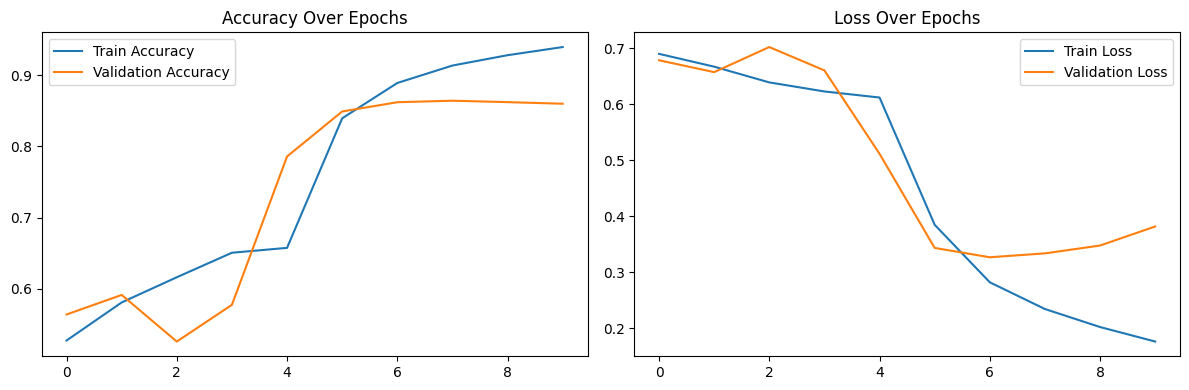

In [13]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - accuracy: 0.8749 - loss: 0.3546

Test Accuracy: 0.8700
Test Loss: 0.3666
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step


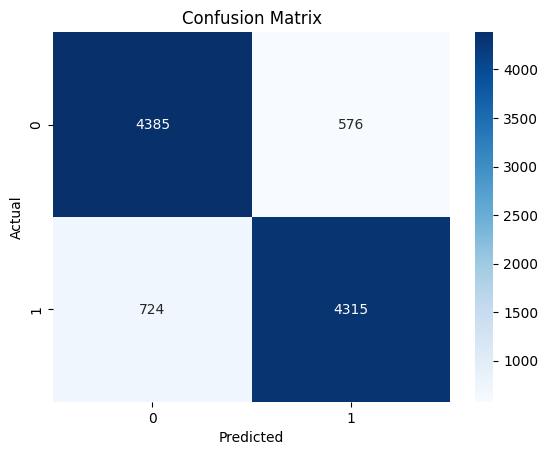


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4961
           1       0.88      0.86      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [14]:
# Test set evaluation
test_loss, test_acc = model.evaluate(X_test_padded, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Confusion Matrix
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [15]:
sample_text = ["This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout.", 
               "Terrible waste of time. Poor acting and a nonsensical storyline."]

# Preprocess
sample_sequences = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_sequences, maxlen=max_length, padding='post', truncating='post')

# Predict
predictions = (model.predict(sample_padded) > 0.5).astype("int32")
sentiments = ['positive' if pred == 1 else 'negative' for pred in predictions]

for text, sentiment in zip(sample_text, sentiments):
    print(f"Text: {text[:60]}...\nPredicted Sentiment: {sentiment}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Text: This movie was absolutely fantastic! The acting was superb a...
Predicted Sentiment: positive

Text: Terrible waste of time. Poor acting and a nonsensical storyl...
Predicted Sentiment: negative

